In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
if not "milligrad" in os.listdir():
    os.chdir('..')

from milligrad import Tensor, Module, Adam, topological_sort
from extras.mnist import load_mnist_data

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = load_mnist_data()

# flattening images and one-hot encoding labels
x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)
y_train, y_test = np.eye(10)[y_train], np.eye(10)[y_test]

# normalizing
mean, std = x_train.mean(), x_train.std()
x_train, x_test = (x_train - mean) / std, (x_test - mean) / std

# standardizing
# train_min, train_max = x_train.min(), x_train.max()
# x_train = (x_train - train_min) / (train_max - train_min)
# x_test = (x_test - train_min) / (train_max - train_min)


In [3]:
from milligrad.tensor import Tensor

class AutoEncoder(Module):
    def __init__(self, layers:list[int]):
        self.encoder = [
            (Tensor.xavier(i, o), Tensor.randn(o))
            for i, o in zip(layers, layers[1:])
        ]
        
        layers = layers[::-1]
        self.decoder = [
            (Tensor.xavier(i, o), Tensor.randn(o))
            for i, o in zip(layers, layers[1:])
        ]
        
    def __call__(self, x:Tensor)->Tensor:
        for w, b in self.encoder:
            x = (x @ w + b).relu()
        for w, b in self.decoder[:-1]:
            x = (x @ w + b).relu()
        
        w, b = self.decoder[-1]
        return (x @ w + b).sigmoid()
    
    def parameters(self) -> list[Tensor]:
        return [param for layer in [self.encoder, self.decoder] for params in layer for param in params]
        
class MLP(Module):
    def __init__(self):
        super().__init__()
        self.w1 = Tensor.xavier(784, 128)
        self.b1 = Tensor.randn(128)
        self.w2 = Tensor.xavier(128, 10)
        self.b2 = Tensor.randn(10)
        
    def __call__(self, x:Tensor)->Tensor:
        x = (x @ self.w1 + self.b1).relu()
        return x @ self.w2 + self.b2
    
    def parameters(self)->list[Tensor]:
        return [self.w1, self.b1, self.w2, self.b2]

In [4]:
# model = AutoEncoder(layers=[784, 128, 64])
model = MLP()
optim = Adam(model.parameters(), lr=1e-3)


for i in range(100):
    y_hat = model(Tensor(x_train[:100]))
    loss = y_hat.categorical_cross_entropy(Tensor(y_train[:100]))
    loss = loss.mean()
    # loss = ((x_hat - Tensor(x_train[:100]))**2).sum().mean()
    
    optim.zero_grad()
    loss.backward()
    optim.step()
        

AttributeError: 'Tensor' object has no attribute 'categorical_cross_entropy'

In [ ]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

accuracy(y_test, model(Tensor(x_test)).data)

0.3388

3


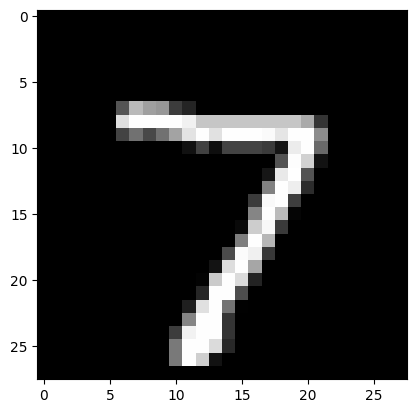

In [ ]:
print(model(Tensor(x_test[0])).data.argmax())

plt.imshow(x_test[0].reshape(28, 28), cmap='gray')

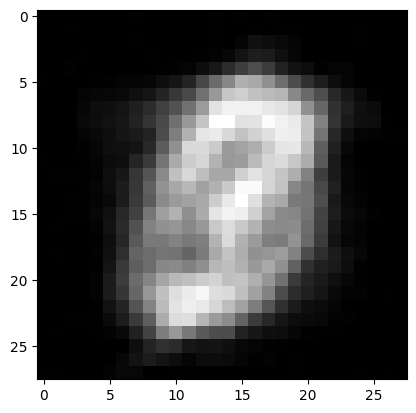

In [ ]:
img = x_hat.data[5].reshape(28, 28)
img = (img * (train_max - train_min)) + train_min

plt.imshow(img, cmap="gray")